In [1]:
%load_ext watermark
%watermark -p torch,pytorch_lightning,torchvision,torchmetrics,matplotlib

torch            : 1.10.1
pytorch_lightning: 1.6.0.dev0
torchvision      : 0.11.2
torchmetrics     : 0.6.2
matplotlib       : 3.3.4



<a href="https://pytorch.org"><img src="https://raw.githubusercontent.com/pytorch/pytorch/master/docs/source/_static/img/pytorch-logo-dark.svg" width="90"/></a> &nbsp; &nbsp;&nbsp;&nbsp;<a href="https://www.pytorchlightning.ai"><img src="https://raw.githubusercontent.com/PyTorchLightning/pytorch-lightning/master/docs/source/_static/images/logo.svg" width="150"/></a>

# VGG16 Smile Classifier with BCELoss

## General settings and hyperparameters

In [2]:
BATCH_SIZE = 256
NUM_EPOCHS = 4
LEARNING_RATE = 0.001
NUM_WORKERS = 4

## Implementing a Neural Network using PyTorch Lightning's `LightningModule`

- For brevity, we load the modules from [`./model.py`](./model.py).

In [3]:
from model import PyTorchVGG16Logits

In [4]:
from model import LightningModelForBCE

## Setting up the dataset

- The CelebA dataset is available at https://mmlab.ie.cuhk.edu.hk/projects/CelebA.html.

In [5]:
from dataset import get_dataloaders_celeba
from torchvision import transforms


custom_transforms = transforms.Compose([
    transforms.CenterCrop((160, 160)),
    transforms.Resize([128, 128]),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_loader, valid_loader, test_loader = get_dataloaders_celeba(
    batch_size=BATCH_SIZE,
    train_transforms=custom_transforms,
    test_transforms=custom_transforms,
    download=False,
    num_workers=4)

### A quick visual check

In [6]:
%matplotlib inline

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision

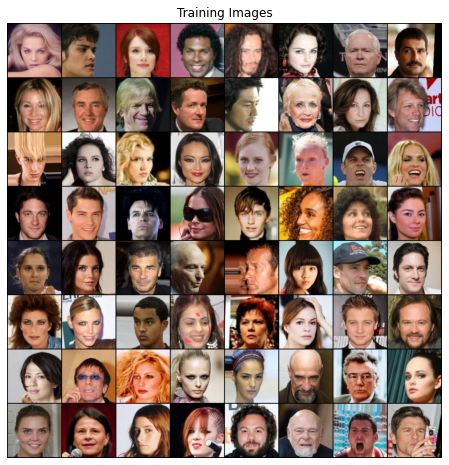

In [8]:
for images, labels in train_loader:  
    break

plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(torchvision.utils.make_grid(
    images[:64], 
    padding=2,
    normalize=True),
    (1, 2, 0)))
plt.show()

## Training the model using the PyTorch Lightning Trainer class

In [9]:
import torch


pytorch_model = PyTorchVGG16Logits(num_outputs=1)
pytorch_model.classifier.add_module('out', torch.nn.Sigmoid())

loss_fn = torch.nn.BCELoss()

lightning_model = LightningModelForBCE(
    model=pytorch_model,
    learning_rate=LEARNING_RATE,
    use_logits=True,
    loss_fn=loss_fn)

- Now it's time to train our model:

In [10]:
import time
import pytorch_lightning as pl


trainer = pl.Trainer(
    max_epochs=NUM_EPOCHS,
    deterministic=True,
    accelerator="auto",  # Uses GPUs or TPUs if available
    devices="auto",  # Uses all available GPUs/TPUs if applicable
)
    
start_time = time.time()
trainer.fit(model=lightning_model, train_dataloaders=train_loader)

runtime = (time.time() - start_time)/60
print(f"Training took {runtime:.2f} min in total.")

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
2022-04-04 18:20:05.778656: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0

  | Name      | Type               | Params
-------------------------------------------------
0 | loss_fn   | BCELoss            | 0     
1 | model     | PyTorchVGG16Logits | 65.1 M
2 | train_acc | Accuracy           | 0     
3 | valid_acc | Accuracy           | 0     
4 | test_acc  | Accuracy           | 0     
-------------------------------------------------
65.1 M    Trainable params
0         Non-trainable params
65.1 M    Total params
260.234   Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

Training took 83.00 min in total.


## Evaluating the model

In [11]:
trainer.test(model=lightning_model, dataloaders=test_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.5003005862236023     │
└───────────────────────────┴───────────────────────────┘

[{'test_acc': 0.5003005862236023}]